In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from useful_functions import *
import csv
from astropy.io import votable
from astropy.table import Table

In [9]:
#Read CSC 2.1 into dataframe
#filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/oldXmatch.csv'
filename='/Users/kciurleo/Documents/kciurleo/AGN/unorganized/CSC2.1p_OIR_SDSSspecmatch.csv'
data=pd.read_csv(filename)

/var/folders/6x/hz5y30457mqg1y9dl2fg7r5m00034d/T/ipykernel_56568/1925374468.py:4: DtypeWarning: Columns (57,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(filename)


In [ ]:
#Read 4XMM-DR13 into dataframe
XMM=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/4XMM_DR13cat_v1.0.csv')

In [ ]:
#Rename XMM ra/dec to avoid confusion later on
XMM['XMM_ra']=XMM['ra']
XMM['XMM_dec']=XMM['dec']

#Add IAU name for easy crossmatching later
XMM['IAU_stripped']=XMM['iauname'].str[5:]

In [10]:
#Find only sources with SDSS data
sources = data.dropna(subset=['Sep_SPEC_CSC21P'])

#Find only non-extended CSC sources
point_sources = sources.loc[sources['extent_flag']==False]

In [11]:
#Saved point sources as csv, which was used in SciServer CasJobs SQL query to get Portsmouth classifications
point_sources.to_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/point_sources.csv', index=False) 

In [12]:
#Portsmouth classifications https://salims.pages.iu.edu/agn/
portsmouth=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/point_sources_classified_lines.csv')

#Agostino classifications https://salims.pages.iu.edu/agn/
agostino=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino2021_table1.csv')

In [13]:
#Get the agostino spectral ids and merge into normal agostino table
agostino_IDs=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/agostino_specIDs.csv')
agostino_full =pd.merge(agostino_IDs, agostino, left_on=['objID'], right_on=['SDSS_ObjID'], how='inner')

#Combine our point source table, portsmouth classification, and agostine classifications
combined = pd.merge(point_sources, portsmouth, left_on=['PLATE', 'MJD', 'FIBERID'],right_on=['plate', 'mjd', 'fiberID'], how='left')
classified_point_sources = pd.merge(combined, agostino_full, left_on =['specobjID'],right_on=['specobjID'],how='left')

#Add IAU name to our sources
classified_point_sources['IAU_stripped']=classified_point_sources['CSC21P_name'].str[5:]

In [142]:
#Make full table of XMM and CSC data
full_point_sources=pd.merge(classified_point_sources,XMM,how='left', on=['IAU_stripped'])

#Subset of point sources with XMM data
XMM_point_sources=full_point_sources.loc[full_point_sources['detid'] >0]

In [144]:
#Find only Seyfert Galaxies, classified as bpt="Seyfert" for Portsmouth and sl_class1=1 for Agostino
portsmouth_s2=full_point_sources.loc[full_point_sources['bpt']=="Seyfert"]
agostino_s2=full_point_sources.loc[full_point_sources['sl_class1']==1]

#Those classified by both
inner_s2=pd.merge(agostino_s2, portsmouth_s2, how='inner')

#Those classified by either
outer_s2=pd.merge(agostino_s2, portsmouth_s2, how='outer')


In [232]:
print(f'Total observations in crossmatch: {len(data)}')
print(f'Sources matched with SDSS: {len(sources)}, {len(data)-len(sources)} not observed with SDSS')
print(f'Point sources: {len(point_sources)}, {len(sources)-len(point_sources)} extended sources')
print(f'Unique point sources with XMM data: {len(XMM_point_sources["IAU_stripped"].unique())}')
print()
print(f'Unique Portsmouth Seyferts:{len(portsmouth_s2["CSC21P_name"].unique())}, {len(point_sources["CSC21P_name"].unique())-len(portsmouth_s2["CSC21P_name"].unique())} non-Seyferts')
print(f'Unique Agostino Seyferts: {len(agostino_s2["CSC21P_name"].unique())}, {len(point_sources["CSC21P_name"].unique())-len(agostino_s2["CSC21P_name"].unique())} non-Seyferts')
print()
print(f'Unique Portsmouth-Agostino Seyferts: {len(inner_s2["CSC21P_name"].unique())}')
print(f'Unique Portsmouth or Agostino Seyferts: {len(outer_s2["CSC21P_name"].unique())}')
print(f'Unique Portsmouth or Agostino Seyferts with XMM data: {len(outer_s2["detid"].unique())}')

Total observations in crossmatch: 387441
Sources matched with SDSS: 17666, 369775 not observed with SDSS
Point sources: 16022, 1644 extended sources
Unique point sources with XMM data: 1146

Unique Portsmouth Seyferts:660, 15362 non-Seyferts
Unique Agostino Seyferts: 130, 15892 non-Seyferts

Unique Portsmouth-Agostino Seyferts: 73
Unique Portsmouth or Agostino Seyferts: 717
Unique Portsmouth or Agostino Seyferts with XMM data: 157


In [243]:
#Ke01 SFR cutoffs from Kewley et al. (2006)
kxNII=np.linspace(-4,0.4,1000)
ke01NII=0.61/(kxNII-0.47)+1.19

kxSII=np.linspace(-4,0.2,1000)
ke01SII=0.72/(kxSII-0.32)+1.30

kxOI=np.linspace(-4,-.8,1000)
ke01OI=0.73/(kxOI+0.59)+1.33

#Ka03 pure star formation line, for [NII] only
kaxNII=np.linspace(-1.2,-.01,1000)
ka03NII=0.61/(kaxNII-0.05)+1.3

#Seyfert/LINER distinctions, for [SII] and [OI] only
slxSII=np.linspace(-0.3,.75,1000)
slSII=1.89*slxSII+0.76

slxOI=np.linspace(-1.1,0,1000)
slOI=1.18*slxOI+1.3

In [244]:
#Errors for plotting
y_error=mult_error_prop([classified_point_sources['Flux_OIII_5006'],classified_point_sources['Flux_Hb_4861']], [classified_point_sources['Flux_OIII_5006'], classified_point_sources['Flux_Hb_4861_Err']])

#[NII]


#[SII]
SII_add_x_error=add_error_prop([classified_point_sources['Flux_SII_6730_Err'],classified_point_sources['Flux_SII_6716_Err']])
SII_x_error = mult_error_prop([classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'],classified_point_sources['Flux_Ha_6562']], [SII_add_x_error, classified_point_sources['Flux_Ha_6562_Err']])

#[OI]

NameError: name 'mult_error_prop' is not defined

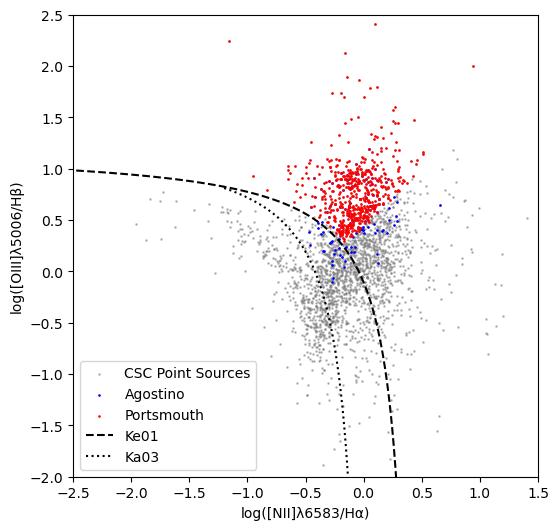

In [245]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.scatter(np.log10(classified_point_sources['Flux_NII_6583']/classified_point_sources['Flux_Ha_6562']),np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), s=3,c='gray',marker='.', alpha=0.5, label='CSC Point Sources')
plt.scatter(np.log10(agostino_s2['Flux_NII_6583']/agostino_s2['Flux_Ha_6562']),np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.', s=3, c='blue', label='Agostino')
plt.scatter(np.log10(portsmouth_s2['Flux_NII_6583']/portsmouth_s2['Flux_Ha_6562']),np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.', s=3, c='red', label='Portsmouth')
plt.plot(kxNII, ke01NII, color='black', linestyle='dashed',label='Ke01')
plt.plot(kaxNII, ka03NII, color='black', linestyle='dotted',label='Ka03')

plt.xlabel("log([NII]λ6583/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xlim(-2.5,1.5)
plt.ylim(-2,2.5)
plt.legend(loc='lower left')

plt.show()

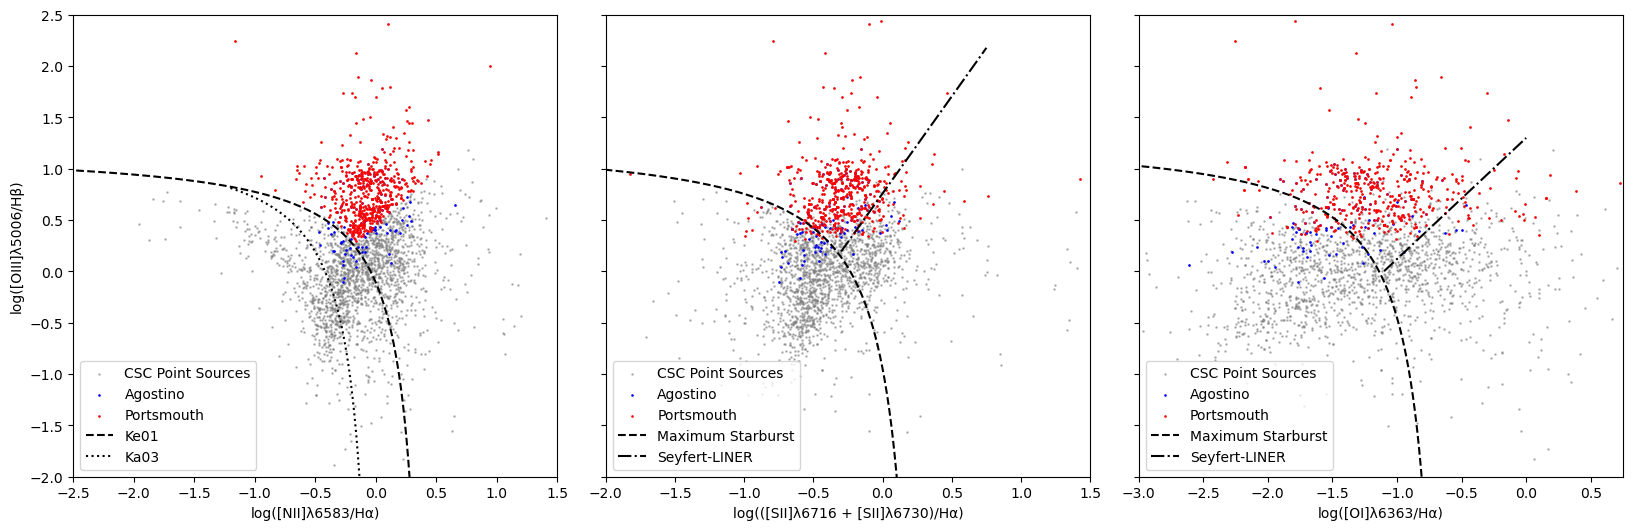

In [259]:
#BPT diagrams in one plot
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True, gridspec_kw={'wspace': 0.1})

#NII
axs[0].scatter(np.log10(classified_point_sources['Flux_NII_6583']/classified_point_sources['Flux_Ha_6562']),
               np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']),
               s=3, c='gray', marker='.', alpha=0.5, label='CSC Point Sources')
axs[0].scatter(np.log10(agostino_s2['Flux_NII_6583']/agostino_s2['Flux_Ha_6562']),
               np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']),
               marker='.', s=3, c='blue', label='Agostino')
axs[0].scatter(np.log10(portsmouth_s2['Flux_NII_6583']/portsmouth_s2['Flux_Ha_6562']),
               np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']),
               marker='.', s=3, c='red', label='Portsmouth')
axs[0].plot(kxNII, ke01NII, color='black', linestyle='dashed', label='Ke01')
axs[0].plot(kaxNII, ka03NII, color='black', linestyle='dotted', label='Ka03')
axs[0].set_xlabel("log([NII]λ6583/Hα)")
axs[0].set_ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
axs[0].set_xlim(-2.5, 1.5)
axs[0].set_ylim(-2,2.5)
axs[0].legend(loc='lower left')

#SII
axs[1].scatter(np.log10((classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'])/classified_point_sources['Flux_Ha_6562']),
               np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']),
               marker='.', s=3, color='gray', alpha=0.5, label='CSC Point Sources')
axs[1].scatter(np.log10((agostino_s2['Flux_SII_6730']+agostino_s2['Flux_SII_6716'])/agostino_s2['Flux_Ha_6562']),
               np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']),
               marker='.', s=3, c='blue', label='Agostino')
axs[1].scatter(np.log10((portsmouth_s2['Flux_SII_6730']+portsmouth_s2['Flux_SII_6716'])/portsmouth_s2['Flux_Ha_6562']),
               np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']),
               marker='.', s=3, c='red', label='Portsmouth')
axs[1].plot(kxSII, ke01SII, color='black', linestyle='dashed', label='Maximum Starburst')
axs[1].plot(slxSII, slSII, color='black', linestyle='-.', label='Seyfert-LINER')
axs[1].set_xlabel("log(([SII]λ6716 + [SII]λ6730)/Hα)")
axs[1].set_xlim(-2, 1.5)
axs[1].set_ylim(-2,2.5)
axs[1].legend(loc='lower left')

#OI
axs[2].scatter(np.log10((classified_point_sources['Flux_OI_6363'])/classified_point_sources['Flux_Ha_6562']),
               np.log10(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']),
               marker='.', s=3, color='gray', alpha=0.5, label='CSC Point Sources')
axs[2].scatter(np.log10((agostino_s2['Flux_OI_6363'])/agostino_s2['Flux_Ha_6562']),
               np.log10(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']),
               marker='.', s=3, c='blue', label='Agostino')
axs[2].scatter(np.log10((portsmouth_s2['Flux_OI_6363'])/portsmouth_s2['Flux_Ha_6562']),
               np.log10(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']),
               marker='.', s=3, c='red', label='Portsmouth')
axs[2].plot(kxOI, ke01OI, color='black', linestyle='dashed', label='Maximum Starburst')
axs[2].plot(slxOI, slOI, color='black', linestyle='-.', label='Seyfert-LINER')
axs[2].set_xlabel("log([OI]λ6363/Hα)")
axs[2].set_xlim(-3, 0.75)
axs[2].set_ylim(-2,2.5)
axs[2].legend(loc='lower left')

plt.show()


In [21]:
#bpt diagrams
plt.figure(figsize=(6,6))

plt.errorbar(((classified_point_sources['Flux_SII_6730']+classified_point_sources['Flux_SII_6716'])/classified_point_sources['Flux_Ha_6562']),(classified_point_sources['Flux_OIII_5006']/classified_point_sources['Flux_Hb_4861']), marker='.', markersize=3,color='gray', alpha=0.5, label='CSC Point Sources',yerr=y_error,xerr=SII_x_error)
plt.scatter(((agostino_s2['Flux_SII_6730']+agostino_s2['Flux_SII_6716'])/agostino_s2['Flux_Ha_6562']),(agostino_s2['Flux_OIII_5006']/agostino_s2['Flux_Hb_4861']), marker='.',s=3, c='blue', label='Agostino')
plt.scatter(((portsmouth_s2['Flux_SII_6730']+portsmouth_s2['Flux_SII_6716'])/portsmouth_s2['Flux_Ha_6562']),(portsmouth_s2['Flux_OIII_5006']/portsmouth_s2['Flux_Hb_4861']), marker='.',s=3, c='red', label='Portsmouth')
plt.plot(10**kxSII, 10**ke01SII, color='black', linestyle='dashed',label='Maximum Starburst')
plt.plot(10**slxSII, 10**slSII, color='black', linestyle='-.',label='Seyfert-LINER')

plt.xlabel("log(([SII]λ6716 + [SII]λ6730)/Hα)")
plt.ylabel("log([OIII]λ5006/Hβ)")
#note these limits are here because of some weird outliers
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-2,10**1.5)
plt.ylim(10**-2,10**2.5)
plt.legend(loc='lower left')

plt.show()

NameError: name 'y_error' is not defined

<Figure size 600x600 with 0 Axes>

In [22]:
#Seth's list of unique unabsorbed candidates(?), not sure where in the pipeline this comes from
colnames=['CXOname', 'OBSID', 'specObjID', 'RA', 'DEC', 'Z', 'nH', 'Counts'] 
seth_list = pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/source_info_obsid_unique_seth.txt', names=colnames, comment='#',sep="  ")
tester_table=pd.merge(classified_point_sources, seth_list, how='inner', left_on='CSC21P_name',right_on='CXOname')

/var/folders/6x/hz5y30457mqg1y9dl2fg7r5m00034d/T/ipykernel_56568/2460985978.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  seth_list = pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/source_info_obsid_unique_seth.txt', names=colnames, comment='#',sep="  ")


In [23]:
print(f"Seth's unabsorbed list: {len(seth_list)}")
print(f"On both lists: {len(tester_table)}")
print(f"On my list: {len(classified_point_sources)}, but still need to weed out wavdetect/below 50 ct sources/unabsorbed")

Seth's unabsorbed list: 323
On both lists: 281
On my list: 16022, but still need to weed out wavdetect/below 50 ct sources/unabsorbed


In [56]:
xml_table=outer_s2[['CSC21P_name','ra','dec']]
xml_table['IAUNAME']=xml_table['CSC21P_name'].str[5:]

/var/folders/6x/hz5y30457mqg1y9dl2fg7r5m00034d/T/ipykernel_56568/769467742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xml_table['IAUNAME']=xml_table['CSC21P_name'].str[5:]


In [61]:
old_data=pd.read_csv('/Users/kciurleo/Documents/kciurleo/AGN/unorganized/oldXmatch.csv')

In [81]:
unique_rows_data = data.merge(old_data, indicator=True, how='left', left_on='CSC21P_name', right_on='CSC2_ID')[lambda x: x['_merge'] == 'left_only'].drop(columns=['_merge'])

In [86]:
print(len(unique_rows_data))
print(len(data))
print(len(old_data))
print(len(data)-len(old_data))

351888
387441
35771
351670


In [154]:
XMM_outer_s2=outer_s2.loc[outer_s2['detid'] >0]

In [153]:
seth_true_list=["J235720.1-005829",
"J104429.3+113810",
"J115930.3+532055",
"J143232.4+340624",
"J080534.7+240951",
"J125830.1-015836",
"J135317.9+332929",
"J153854.0+170137",
"J014209.0-005050",
"J134736.4+173404",
"J081145.3+232825",
"J142841.1+323222",
"J115852.2+424320"]

In [155]:
XMM_outer_s2[XMM_outer_s2['IAU_stripped'].isin(seth_true_list)]

,CSC21P_name,ra_x,dec_x,likelihood_class,extent_flag,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,flux_aper_b,...,sc_ep_8_fmin_err,sc_ep_8_fmax,sc_ep_8_fmax_err,mjd_first,mjd_last,n_detections,confused,high_background,XMM_ra,XMM_dec
559,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901640,17.567958
560,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901976,17.567607
561,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901640,17.567938
562,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.902272,17.567583
563,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.902066,17.567721
564,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901044,17.568246
565,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901051,17.567927
566,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.901791,17.567733
567,2CXO J134736.4+173404,206.901667,17.56794,TRUE,False,0.71614,0.715051,151.537133,13.510591,3.393152e-13,...,4.847249e-14,7.282900e-13,6.677797e-14,52814.157106,55946.957558,9.0,f,f,206.902036,17.567864


In [159]:
pd.read_csv('/Users/kciurleo/Documents/kciurleo/new_file.csv')

,RADEG,DECDEG,IAUNAME,CHANDRA_OBSID
0,0.007698,14.024564,J000001.8+140128,J000001.8+140128
1,1.007698,14.024564,J000001.8+140128,J000001.8+140128
2,2.007698,14.024564,J000001.8+140128,J000001.8+140128


In [162]:
classified_point_sources[classified_point_sources['IAU_stripped'].isin(seth_true_list)]

,CSC21P_name,ra,dec,likelihood_class,extent_flag,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,flux_aper_b,...,Flux_SII_6730,Flux_SII_6730_Err,Flux_OI_6363,Flux_OI_6363_Err,objID,SDSS_ObjID,gen_el_class,sl_class1,sl_class2,IAU_stripped
1219,2CXO J014209.0-005050,25.537575,-0.847252,TRUE,False,0.710904,0.710565,82.134537,23.525578,3.043410e-13,...,98.044530,16.736120,5.179852,6.785204,1.237657e+18,1.237657e+18,5.0,1.0,1.0,J014209.0-005050
2835,2CXO J081145.3+232825,122.938814,23.473876,TRUE,False,0.772866,0.761060,105.354098,2.702703,3.231904e-15,...,64.652080,4.943286,14.526220,4.463283,NaN,NaN,NaN,NaN,NaN,J081145.3+232825
6236,2CXO J104429.3+113810,161.122114,11.636376,TRUE,False,2.965642,2.072851,91.362308,3.333333,2.197963e-14,...,44.010520,12.255660,8.405495,7.712914,1.237661e+18,1.237661e+18,5.0,1.0,1.0,J104429.3+113810
8139,2CXO J115930.3+532055,179.876264,53.348816,TRUE,False,0.736751,0.731579,98.703095,3.371429,2.698659e-14,...,125.072200,11.233980,78.419590,23.759050,NaN,NaN,NaN,NaN,NaN,J115930.3+532055
9862,2CXO J125830.1-015836,194.625769,-1.976809,MARGINAL,False,6.912127,3.616240,42.532975,3.636364,0.000000e+00,...,415.863300,19.779880,47.190610,11.460640,NaN,NaN,NaN,NaN,NaN,J125830.1-015836
10835,2CXO J134736.4+173404,206.901667,17.567940,TRUE,False,0.716140,0.715051,151.537133,13.510591,3.393152e-13,...,177.470500,6.991809,45.761100,5.844390,NaN,NaN,NaN,NaN,NaN,J134736.4+173404
10951,2CXO J135317.9+332929,208.324704,33.491413,TRUE,False,0.783603,0.783603,0.000000,4.594595,2.740207e-15,...,1317.272000,65.781450,435.735500,66.931560,NaN,NaN,NaN,NaN,NaN,J135317.9+332929
11978,2CXO J142841.1+323222,217.171263,32.539594,TRUE,False,0.802384,0.774075,24.566207,9.301724,2.195996e-13,...,168.700400,17.501150,71.140850,25.319030,1.237665e+18,1.237665e+18,5.0,1.0,1.0,J142841.1+323222
12244,2CXO J143232.4+340624,218.135410,34.106902,TRUE,False,2.381376,1.459633,15.405739,3.085714,8.354569e-15,...,176.786800,10.451690,24.323910,7.726170,1.237663e+18,1.237663e+18,5.0,1.0,1.0,J143232.4+340624
15983,2CXO J235720.1-005829,359.333916,-0.974908,TRUE,False,0.810391,0.755359,81.777545,16.170926,8.609062e-14,...,9.911661,6.223437,5.155740,5.212724,NaN,NaN,NaN,NaN,NaN,J235720.1-005829


In [167]:
seth_finals_not_in_points=["2CXO J080534.7+240951",
"2CXO J153854.0+170137",
"2CXO J115852.2+424320"]

In [168]:
data[data['CSC21P_name'].isin(seth_finals_not_in_points)]

,CSC21P_name,ra,dec,likelihood_class,extent_flag,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,flux_aper_b,...,Z_ERR,RCHI2,DOF,WAVEMIN,WAVEMAX,ZWARNING,SN_MEDIAN_ALL,GroupID,GroupSize,Sep_SPEC_CSC21P
178709,2CXO J115852.2+424320,179.717765,42.722357,TRUE,True,0.722261,0.72027,116.312643,8.263364,3.064567e-14,...,0.000011,5.887371,3751.0,3805.3972,9187.556,0.0,47.288277,46.0,2.0,0.734782


In [185]:
contains_it=data['CSC21P_name'].str.contains('J153854', na=False)
data[contains_it]

,CSC21P_name,ra,dec,likelihood_class,extent_flag,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,flux_aper_b,...,Z_ERR,RCHI2,DOF,WAVEMIN,WAVEMAX,ZWARNING,SN_MEDIAN_ALL,GroupID,GroupSize,Sep_SPEC_CSC21P
255613,2CXO J153854.0+170137X,234.725084,17.027149,TRUE,True,2.914966,2.914966,0.000000,9.538464,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255614,2CXO J153854.0+170015,234.725413,17.004400,TRUE,False,0.864640,0.752797,144.658650,2.850000,2.976130e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255615,2CXO J153854.1+170134,234.725665,17.026229,TRUE,True,0.711282,0.711275,0.000000,22.651270,3.040495e-13,...,0.000012,7.667066,3780.0,3808.0269,9210.856,0.0,43.773777,NaN,NaN,0.158929
255616,2CXO J153854.7+430438,234.727910,43.077402,TRUE,False,5.219298,4.166980,1.733815,3.794872,4.300822e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255617,2CXO J153854.6-530945,234.727937,-53.162624,TRUE,False,1.471638,0.969433,162.103657,2.285714,2.701454e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
255618,2CXO J153854.9+170211,234.728896,17.036594,TRUE,False,0.751993,0.748360,69.886226,3.405405,2.347469e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
#Pulled Seth's 1252 total observations, before throwing away those with at least 50 counts, which are 663 unique objects
seth_candidates = pd.read_csv('/Users/kciurleo/Documents/kciurleo/all_info_final.csv')
data_overlap = pd.merge(seth_candidates, data, left_on=['SDSS Plate','SDSS Fiber', 'SDSS MJD'], right_on=['PLATE','FIBERID','MJD'], how='inner')
point_overlap=pd.merge(seth_candidates, point_sources, left_on=['SDSS Plate','SDSS Fiber', 'SDSS MJD'], right_on=['PLATE','FIBERID','MJD'], how='inner')
s2_overlap = pd.merge(seth_candidates, outer_s2, left_on=['SDSS Plate','SDSS Fiber', 'SDSS MJD'], right_on=['PLATE','FIBERID','MJD'], how='inner')

In [237]:
print(f"Seth's unique candidates: {len(seth_candidates['# Name'].unique())}")
print(f"Seth's unique candidates present in CSC2.1: {len(data_overlap['# Name'].unique())}, {len(seth_candidates['# Name'].unique())-len(data_overlap['# Name'].unique())} missing")
print(f"Seth's unique candidates present in CSC2.1 point sources: {len(point_overlap['# Name'].unique())}, {len(data_overlap['# Name'].unique())-len(point_overlap['# Name'].unique())} extended sources")
print(f"Seth's unique candidates present in CSC2.1 outer Seyferts: {len(s2_overlap['# Name'].unique())}, wait where did these go")
print()
print(f"Unique non-Seth candidates present in CSC2.1 outer Seyferts: {len(outer_s2['CSC21P_name'].unique())-len(s2_overlap['# Name'].unique())}")

Seth's unique candidates: 663
Seth's unique candidates present in CSC2.1: 559, 104 missing
Seth's unique candidates present in CSC2.1 point sources: 499, 60 extended sources
Seth's unique candidates present in CSC2.1 outer Seyferts: 476, wait where did these go

Unique non-Seth candidates present in CSC2.1 outer Seyferts: 241


In [233]:
len(outer_s2['CSC21P_name'].unique())

717